# Testando scripts úteis

In [38]:
import os
import re

def instances_params(folderpath):
    regex = re.compile(r"(?P<letter>\w)(?P<value>[\d_]+)")

    exp_list = []
    for filename in os.listdir(folderpath):
        filepath = os.path.join(folderpath, filename)

        if os.path.isfile(filepath):
            filename = os.path.basename(filepath)
            instance_name = filename.split('.')[0]

            param_dict = {}

            for param_pair_str in instance_name.split('-'):
                m = regex.match(param_pair_str)

                if m != None:
                    param_dict[m.group('letter')] = m.group('value')
            if 'd' in param_dict.keys():
                param_dict['d'] = param_dict['d'].replace('_', ', ')

            exp_list.append(param_dict)

    exp_list.sort(key=lambda el: (int(el['n']), int(el['m']), int(el['Q']), int(el['s']), el['d']))
    
    letters = ['n', 'm', 'Q', 'v', 'd']
    for l in letters:
        print(l, end='\t')
    print('')
    
    for exp in exp_list:

        for l in letters:
            print(exp[l], end='\t')
        print('')

folderpath = "Instancias/Vrp-Set-A_MMURP/test"
instances_params(folderpath)

n	m	Q	v	d	
50	4	80	4	1, 1, 1, 1	
50	4	80	6	2, 2, 1, 1	
50	4	80	10	3, 3, 2, 2	
50	4	160	4	1, 1, 1, 1	
50	4	160	5	2, 1, 1, 1	
100	2	100	3	2, 1	
100	2	100	6	3, 3	
100	2	100	9	5, 4	
100	2	100	15	8, 7	
100	4	100	6	2, 2, 1, 1	
100	4	100	9	3, 2, 2, 2	
100	4	100	12	3, 3, 3, 3	
100	4	100	15	4, 4, 4, 3	
249	2	500	20	10, 10	
249	2	500	25	13, 12	
249	2	500	5	3, 2	
249	2	500	10	5, 5	
249	2	500	15	8, 7	


In [84]:
# %ls ../project/resultados/exp_20221005/n50 | wc -l
# %load_ext autoreload
# %autoreload 2
    
from src.util_experiments import nsga_output_to_df
# import src.mo as mo

folderpath = "../project/resultados/exp_20221005/n50/"

df_nsga = nsga_output_to_df(folderpath)
df_nsga.head()

,name,mutation_rate,number_generations,population_size,ref_point,duracao,hv,non_dominated
0,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",24333.2,1.470274e+06,17
1,A-n50-m4-Q160-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",83562.9,2.767469e+06,15
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,0.4,20.0,100.0,"4709.81, 0",2803080.0,3.315824e+06,24
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",26555.1,1.476775e+06,28
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,0.4,20.0,100.0,"4709.81, 0",112607.0,2.173878e+06,29


In [ ]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


df_nsga = nsga_output_to_df(nsga_folderpath)

instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    
    ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
    hv_model = mo.hypervolume(pop, ref_point)
    
    df_nsga[df_nsga.name == instance].boxplot(column='hv', figsize=(3, 4))
    
    plt.axhline(y=hv_model, color='#ff3300', linestyle='--', linewidth=1, label='Model Hypervolume')
    plt.title(instance)
    
    plt.tight_layout()

    plt.show()

In [103]:
import re
import pandas as pd

def parser_result_exp(filepath):
    
    def end_of_run(line):
        return '*****************' in line
    
    def read_starting(line):
        return str(line.split('Starting on instance')[1].strip())

    def read_build_model_time(line):
        return float(line.split(' ')[1].strip())

    def read_build_pareto_time(line):
        return float(line.split(' ')[1].strip())


    readers = {
        'Starting on instance': ('instance', read_starting),
        'build_model:': ('build_model', read_build_model_time),
        'build_pareto:': ('build_pareto', read_build_pareto_time),
    #     '': '',
    }

    runned_instances = []
    with open(filepath, mode='r') as file:
        instance_dict = {}
        for line in file:
            if end_of_run(line):
                runned_instances.append({**instance_dict})
                instance_dict = {}
            
            for reader in readers:
                reader_name = readers[reader][0]
                if reader_name in line:
                    reader_f = readers[reader][1]
                    instance_dict[reader_name] = reader_f(line)
                    break

    return pd.DataFrame(runned_instances)

search_path = '../project/resultados/exp_20220927/exp_*.log'

frames = []
for filepath in glob.glob(search_path):
    frames.append(parser_result_exp(filepath))

df_model = pd.concat(frames)

folderpath = "../project/resultados/exp_20221005/n50/"
df_nsga = nsga_output_to_df(folderpath)

In [110]:
folderpath = "../project/resultados/exp_20221005/n50/"
df = nsga_output_to_df(folderpath)
df_nsga_mean = (df[['name', 'duracao', 'hv', 'non_dominated']].groupby(by='name').mean()).reset_index()

,name,duracao,hv,non_dominated
0,A-n50-m4-Q160-v4-s100-d1_1_1_1,83154.10,2.769714e+06,17.5
1,A-n50-m4-Q160-v5-s100-d2_1_1_1,238904.90,3.203795e+06,12.1
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,2954781.00,3.309000e+06,26.4
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,26992.93,1.474365e+06,24.7
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,117235.20,2.167940e+06,31.2


In [111]:
folderpath = "../project/resultados/exp_20221005/n50/"
df = nsga_output_to_df(folderpath)
df_nsga_mean = (df[['name', 'duracao', 'hv', 'non_dominated']].groupby(by='name').mean()).reset_index()

result = pd.merge(
    df_nsga_mean,
    df_model,
    how='left',
    left_on='name',
    right_on='instance'
)
result.drop(columns=['instance'], inplace=True)
result.head()

,name,duracao,hv,non_dominated,build_model,build_pareto
0,A-n50-m4-Q160-v4-s100-d1_1_1_1,83154.10,2.769714e+06,17.5,0.315368,3483.099560
1,A-n50-m4-Q160-v5-s100-d2_1_1_1,238904.90,3.203795e+06,12.1,0.318783,2680.610028
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,2954781.00,3.309000e+06,26.4,0.318352,3320.782163
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,26992.93,1.474365e+06,24.7,0.324585,3096.733128
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,117235.20,2.167940e+06,31.2,0.315963,3418.887884


In [72]:
# !head ../project/resultados/exp_20220927/exp_20220926.log -n 20
%ls ../project/resultados/exp_20220927/*.log

../project/resultados/exp_20220927/bash_test.log
../project/resultados/exp_20220927/exp_20220926.log
../project/resultados/exp_20220927/exp_20220927.log


## Gerando gráficos

### Hipervolume execuções do algoritmo e do modelo por instância

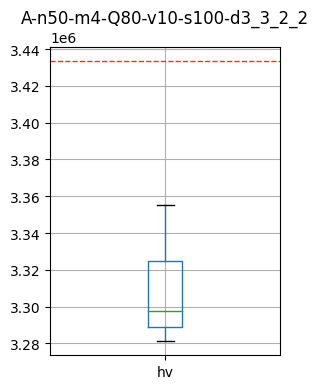

In [26]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


df_nsga = nsga_output_to_df(nsga_folderpath)
instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    
    ref_point = [float(v) for v in df_nsga[df_nsga.name == instance].ref_point.values[0].split(',')]
    hv_model = mo.hypervolume(pop, ref_point)
    
    df_nsga[df_nsga.name == instance].boxplot(column='hv', figsize=(3, 4))
    
    plt.axhline(y=hv_model, color='#ff3300', linestyle='--', linewidth=1, label='Model Hypervolume')
    plt.title(instance)
    
    plt.tight_layout()

    plt.show()
    break

### Quantidade de pontos não dominados por instância

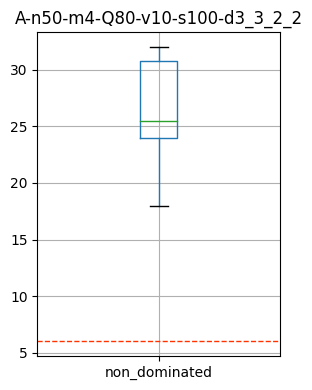

In [30]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


df_nsga = nsga_output_to_df(nsga_folderpath)
instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
    sol_path = solutions[0]
    df = clean_sol_csv_file(sol_path)
    pop = df[['dist', 'demand']].values*[1, -1]
    non_dominated, _ = mo.no_dominated(pop)
            
    df_nsga[df_nsga.name == instance].boxplot(column='non_dominated', figsize=(3, 4))
    
    plt.axhline(y=len(non_dominated), color='#ff3300', linestyle='--', linewidth=1, label='Model Non Dominated')
    plt.title(instance)
    
    plt.tight_layout()

    plt.show()
    break

In [31]:
model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


df_nsga = nsga_output_to_df(nsga_folderpath)
df_nsga.head()

,name,mutation_rate,number_generations,population_size,ref_point,duracao,hv,non_dominated
0,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",24333.2,1.470274e+06,17
1,A-n50-m4-Q160-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",83562.9,2.767469e+06,15
2,A-n50-m4-Q80-v10-s100-d3_3_2_2,0.4,20.0,100.0,"4709.81, 0",2803080.0,3.315824e+06,24
3,A-n50-m4-Q80-v4-s100-d1_1_1_1,0.4,20.0,100.0,"4709.81, 0",26555.1,1.476775e+06,28
4,A-n50-m4-Q80-v6-s100-d2_2_1_1,0.4,20.0,100.0,"4709.81, 0",112607.0,2.173878e+06,29


### Tempo de execução do algoritmo por instância

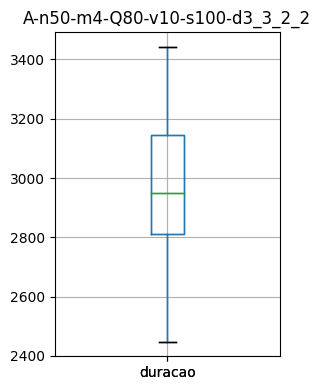

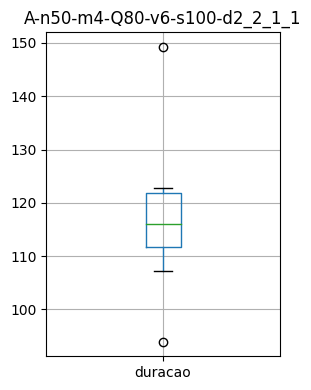

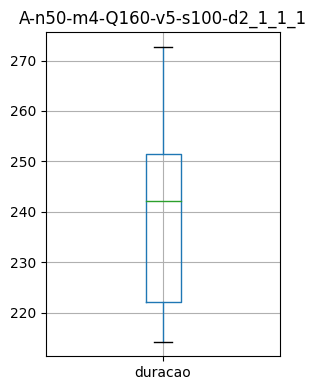

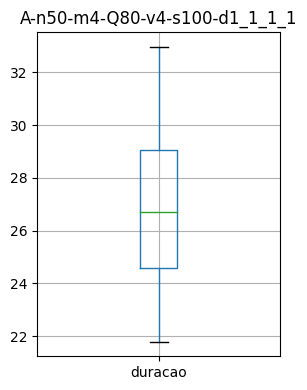

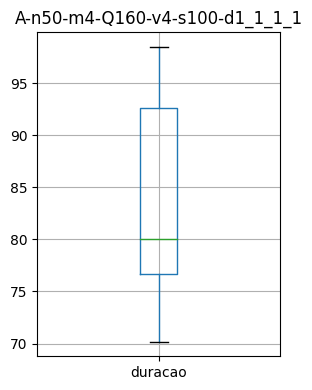

In [36]:
import glob
from src.util_experiments import clean_sol_csv_file
import matplotlib.pyplot as plt

model_folderpath = "../project/resultados/exp_20220927/"
nsga_folderpath = "../project/resultados/exp_20221005/n50/"


df_nsga = nsga_output_to_df(nsga_folderpath)
df_nsga['duracao'] = df_nsga.duracao / 1000.0

instances = list(set(df_nsga.name.values))
for instance in instances:
    solutions = list(glob.glob(f"{model_folderpath}/{instance}_sol_*.csv"))
    
    if len(solutions)>1:
        raise Exception("Have more than one model solution for this instance")
    
#     sol_path = solutions[0]
#     df = clean_sol_csv_file(sol_path)
#     pop = df[['dist', 'demand']].values*[1, -1]
#     non_dominated, _ = mo.no_dominated(pop)
            
    df_nsga[df_nsga.name == instance].boxplot(column='duracao', figsize=(3, 4))
    
#     plt.axhline(y=len(non_dominated), color='#ff3300', linestyle='--', linewidth=1, label='Model Non Dominated')
    plt.title(instance)
    plt.tight_layout()

    plt.show()
#     break

In [ ]:
import matplotlib.pyplot as plt


figure, axis = plt.subplots(5, 1, figsize=(12, 24), tight_layout=True)

instances = list(set(df.name.values))

k = 0
for i in range(5):
    cur_axis = axis[i]

    if k < len(instances):
        inst_id = instances[i]
        instance_name = instances[i]
        avg = df[df.name == 'A-n50-m4-Q80-v6-s100-d2_2_1_1'].hv.mean()
        
        df[df.name == inst_id].boxplot(column='hv', ax=cur_axis)
        plt.scatter(0, avg, c='tab:orange', )
        
        cur_axis.set_title(f"{instance_name}")
    
    else:
        cur_axis.set_visible(False)
    k = k + 1